> # Introduction

In this competition, we're tasked with creating an agent that can play [Connect Four](https://en.wikipedia.org/wiki/Connect_Four) and, hopefully, win against another agent.

Connect Four is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. 

The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs.

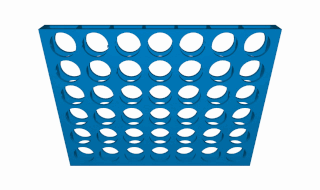

In this notebook, we will train a Neural Network based agent using a policy gradient algorithm, [Proximal Policy Optimization (PPO)](https://arxiv.org/pdf/1707.06347.pdf).

Inspired by [this paper](https://arxiv.org/abs/1710.03748), we will use a multi-agent environment, we train two agents to play against each other, 
with a dense exploration reward during the beginning of the training.

By default, the agents receive a reward only at the end of the game which can hinder their ability to learn to play the game.

That's why we have decided to augment the game's reward with a dense exploration reward that is linearly decreased according to the equation:

$reward = \alpha * \text{exploration_reward} + (1 - \alpha) * \text{game_reward}$

$\alpha$ is the annealing factor that decays linearly with time.

The exploration reward that will be used is composed of 2 components:
- A component that rewards the agent ( i.e. positive reward ) for playing discs in consecutive positions 
- A component that punishes the agent ( i.e. negative reward ) for the opponents' discs in consecutive positions

In all games, the agents will alternate between going first and going second.

# Libraries

In [ ]:
from collections import defaultdict
from enum import IntEnum, unique, auto
import logging
import os
from pathlib import Path
import pickle
import random
import sys
from typing import Tuple, Union

logger = logging.basicConfig(level=logging.INFO)

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR

import numpy as np

from kaggle_environments import make, evaluate
from kaggle_environments.utils import structify
from gym import spaces

In [ ]:
import ray
from ray import tune
import ray.rllib.agents.ppo as ppo
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.recurrent_net import RecurrentNetwork
from ray.rllib.utils.annotations import override
from ray.tune.registry import ENV_CREATOR, register_env, _global_registry
from ray.tune import JupyterNotebookReporter
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.rllib.env import MultiAgentEnv
from ray.rllib.evaluation.episode import MultiAgentEpisode
from ray.rllib.env.base_env import _DUMMY_AGENT_ID
from ray.rllib.utils.typing import AgentID, PolicyID

This is required to enable RLLib's sample compression

In [ ]:
!pip install lz4

We print here the versions of the important packages for repeatability's sake

In [ ]:
!pip list | grep -wE "ray|torch|kaggle-environments"

In [ ]:
# Load the TensorBoard extension
%load_ext tensorboard

# Constants

We define some constants that will be used throughout the notebook

In [ ]:
RANDOM_SEED = 16

In [ ]:
CURRENT_PATH = !pwd
CURRENT_PATH = Path(CURRENT_PATH[0])

We pin the random seed in order to ensure repeatability

In [ ]:
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

We initialize ray in order to be able to run the training

In [ ]:
ray.init(ignore_reinit_error=True)

# Environment

This is a multi-agent environment is the most complicated piece of code in this notebook.

It contains lots of hacks to allow the use of two agents at the same time, to change the reward and to update the annealing factor.

In [ ]:
class ConnectFourGym(MultiAgentEnv):
    def __init__(self, config=None):
        if config is None:
            config = dict(annealing_factor_last_iteration=0)
        self.agent1 = "agent1"
        self.agent2 = "agent2"
        self.annealing_factor_last_iteration = config.get("annealing_factor_last_iteration")
        
        self.connectx_env = make("connectx", debug=True)
        # Size of the board
        self.rows = self.connectx_env.configuration.rows
        self.columns = self.connectx_env.configuration.columns
        self.n_cells = self.rows * self.columns
        # Number of consecutive discs needed to win the game
        self.inarow = self.connectx_env.configuration.inarow
        
        # Patterns that will be search for in the _change_reward method
        self.patterns = { 
            num_discs: [
                np.array([[1] * num_discs]),
                np.array([[1]] * num_discs),
                np.array([[1 if j == i else 0 for j in range(num_discs)] for i in range(num_discs)]),
                np.array([[1 if j == i else 0 for j in range(num_discs)] for i in reversed(range(num_discs))]),
            ]
            for num_discs in range(1, self.inarow + 1)
        }
        
        # Linear annealing factor used to used to slowly 
        # reduce the exploration component of the reward to zero
        # r = alpha * exploration_reward + (1 - alpha) * normal_reward
        # https://arxiv.org/pdf/1710.03748.pdf
        self.alpha = 0.0
        
        self.env = self._create_environment()
        
        # Action and Observation Spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(
            low=-1, 
            high=1, 
            shape=(self.rows,self.columns,1), 
            dtype=np.int
        )
        
        # These are used to keep track of the agents' number of wins and losses
        self.agent_wins = defaultdict(int)
        
        self.n_step = 0
        self.n_episodes = 0

    def reset(self):
        self.n_step = 0
        self.env = self._create_environment()
        obs_dict = self.env.reset()
        for k, obs in obs_dict.items():
            observation = np.array(obs["board"]).reshape(self.rows, self.columns, 1)
            observation = np.where(observation == obs.mark, 1, observation)
            observation = np.where(observation == obs.mark % 2 + 1, -1, observation)
            obs_dict[k] = observation
        return obs_dict
    
    def _create_environment(self):        
        def advance(position: int):
            while not self.connectx_env.done and self.connectx_env.state[position].status == "INACTIVE":
                self.connectx_env.step((None, None))

        def reset():
            self.connectx_env.reset(2)
            advance(0)
            return {"agent1": self.connectx_env._Environment__get_shared_state(0).observation, "agent2": self.connectx_env._Environment__get_shared_state(0).observation}

        def step(agent, action):
            if agent == "agent1":
                actions = (action, None)
                position = 0
            else:
                actions = (None, action)
                position = 1
            self.connectx_env.step(actions)
            agent = self.connectx_env._Environment__get_shared_state(position)
            reward = agent.reward
            if len(self.connectx_env.steps) > 1 and reward is not None:
                reward -= self.connectx_env.steps[-2][position].reward
            return [
                agent.observation, reward, agent.status == "DONE" or agent.status == "INVALID", agent.info
            ]

        reset()
        
        return structify({"step": step, "reset": reset})

    def step(self, actions_dict):
        self.n_step += 1
        obs, reward, done, info = {}, {}, {}, {}
        for agent_id, action in actions_dict.items():
            obs[agent_id], old_reward, done[agent_id], info[agent_id] = self.env.step(agent_id, int(action))
            info[agent_id] = dict(**info[agent_id])
            reward[agent_id] = self.change_reward(obs[agent_id], old_reward if old_reward is not None else -1, done[agent_id], agent_id)
            observation = np.array(obs[agent_id]["board"]).reshape(self.rows, self.columns, 1)
            observation = np.where(observation == obs[agent_id].mark, 1, observation)
            observation = np.where(observation == obs[agent_id].mark % 2 + 1, -1, observation)
            obs[agent_id] = observation
            if done[agent_id] and agent_id == "agent1":
                observation = np.where(observation == -1, 2, observation)
                observation = np.where(observation == 1, -1, observation)
                observation = np.where(observation == 2, 1, observation)
                obs["agent2"] = observation
                info["agent2"] = {}
                done["agent2"] = True
                if old_reward is None or old_reward == -1:
                    agent2_reward = 1
                else:
                    agent2_reward = -1
                reward["agent2"] = self.change_reward(obs["agent2"], agent2_reward, done["agent2"], agent_id)
                break
        done["__all__"] = any(done.values())
        if done["__all__"]:
            if reward["agent1"] > reward["agent2"]:
                self.agent_wins["agent1"] += 1
            elif reward["agent2"] > reward["agent1"]:
                self.agent_wins["agent2"] += 1
            self.n_episodes += 1
        return obs, reward, done, info
    
    def change_reward(self, obs, old_reward: int, done: bool, agent_id: str):
        if old_reward is None:
            return -1000
        elif old_reward == 1:
            reward = 100.0 + 100.0 * (self.n_cells - self.n_step) / self.n_cells 
            return reward
        elif done:
            reward = - 100.0 - 100.0 * (self.n_cells - self.n_step) / self.n_cells 
            return reward
        else:
            reward = 0.0
        if self.alpha > 0.0:
            exploration_reward = self.compute_exploration_reward(obs)
            reward = self.alpha * exploration_reward + (1 - self.alpha) * reward
        return reward
    
    def compute_exploration_reward(self, obs):
        grid = np.asarray(obs["board"]).reshape(self.rows, self.columns)
        twos_count = self._count_windows(grid, num_discs=2, piece=obs.mark)
        threes_count = self._count_windows(grid, num_discs=3, piece=obs.mark)
        fours_count = self._count_windows(grid, num_discs=4, piece=obs.mark)
        opp_twos_count = self._count_windows(grid, num_discs=2, piece=obs.mark % 2 + 1)
        opp_threes_count = self._count_windows(grid, num_discs=3, piece=obs.mark % 2 + 1)
        exploration_reward = 100*fours_count+ 10*threes_count + 1*twos_count
        exploration_reward -= 100*opp_threes_count + 10*opp_twos_count
        return exploration_reward
    
    def _count_windows(self, grid, num_discs, piece):
        num_windows = 0
        # horizontal
        for row in range(self.rows):
            for col in range(self.columns-(self.inarow-1)):
                window = list(grid[row, col:col+self.inarow])
                if self._check_window(window, num_discs, piece):
                    num_windows += 1
        # vertical
        for row in range(self.rows-(self.inarow-1)):
            for col in range(self.columns):
                window = list(grid[row:row+self.inarow, col])
                if self._check_window(window, num_discs, piece):
                    num_windows += 1
        # positive diagonal
        for row in range(self.rows-(self.inarow-1)):
            for col in range(self.columns-(self.inarow-1)):
                window = list(grid[range(row, row+self.inarow), range(col, col+self.inarow)])
                if self._check_window(window, num_discs, piece):
                    num_windows += 1
        # negative diagonal
        for row in range(self.inarow-1, self.rows):
            for col in range(self.columns-(self.inarow-1)):
                window = list(grid[range(row, row-self.inarow, -1), range(col, col+self.inarow)])
                if self._check_window(window, num_discs, piece):
                    num_windows += 1
        return num_windows
    
    def _check_window(self, window, num_discs, piece):
        return (window.count(piece) == num_discs and window.count(0) == self.inarow-num_discs)
    
    def seed(self, initial_state):
        """Method required by rllib"""
        pass
        
    def update_alpha(self, iteration: int):
        """Compute the new value of the annealing factor given the current iteration number"""
        if iteration < self.annealing_factor_last_iteration:
            self.alpha = 1.0 - iteration / self.annealing_factor_last_iteration
        else:
            self.alpha = 0.0

register_env("ConnectFourGym-v0", lambda config: ConnectFourGym(config))

In [ ]:
environment = ConnectFourGym()

# Neural Network

We define the Neural Network model used for the policy and the value function

In [ ]:
class ConnectFourNetwork(TorchModelV2, nn.Module):
    def __init__(
        self, 
        obs_space, 
        action_space, 
        num_outputs, 
        model_config, 
        name,
        network_width: int = 512,
        **kwargs,
    ):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        
        self.input_size = obs_space.shape[0] * obs_space.shape[1] * obs_space.shape[2]
        
        self.shared_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_size, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
        )
        
        self.policy_output = nn.Linear(network_width, num_outputs)
        self.vf_layers = nn.Linear(network_width, 1)
        
        # Initialize policy's output layer's weights to very small values
        # in order to make its output uniform
        torch.nn.init.xavier_normal_(self.policy_output.weight, gain=1e-5)
        self.policy_output.bias.data.fill_(1e-3)
        
        self._output = None
        
    @override(TorchModelV2)
    def forward(self, input_dict, state, seq_lens):
        x = input_dict["obs"]
        x = x.type(torch.float)
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        self._output = self.shared_layers(x)
        model_output = self.policy_output(self._output)
        return model_output, []
    
    @override(TorchModelV2)
    def value_function(self):
        assert self._output is not None, "must call forward first!"
        return torch.reshape(self.vf_layers(self._output), [-1])

    
ModelCatalog.register_custom_model("ConnectFourNetwork", ConnectFourNetwork)

# Training

This helper function is used to load checkpoints for the special policies 'agent1_checkpoint' and 'agent2_checkpoint'

In [ ]:
def restore_model_checkpoint(policy, agent_id: str, path: str):
    with open(path, "rb") as f:
        checkpoint_data = pickle.load(f)
    checkpoint_state = pickle.loads(checkpoint_data["worker"])["state"]
    network_checkpoint_data = checkpoint_state.get(agent_id)
    del network_checkpoint_data["_optimizer_variables"]
    
    for k, v in network_checkpoint_data.items():
        network_checkpoint_data[k] = torch.from_numpy(v).to("cpu")
        
    print(f"Restoring Model for Agent '{agent_id}' From Checkpoint at '{path}'")
    policy.model.load_state_dict(network_checkpoint_data)


This is a hack used in order to be able to check the previous mapped agent policies in order to determine the current one

In [ ]:
def override_policy_for(self, agent_id: AgentID = _DUMMY_AGENT_ID) -> PolicyID:
    if agent_id not in self._agent_to_policy:
        self._agent_to_policy[agent_id] = self._policy_mapping_fn(agent_id, self._agent_to_policy)
    return self._agent_to_policy[agent_id]

This class contains callbacks that are used at different points during the training to control certain aspects of it

In [ ]:
class TrainingCallbacks(DefaultCallbacks):
    def on_episode_start(
        self, 
        *, 
        worker, 
        base_env, 
        policies,
        episode,
        **kwargs
    ):
        MultiAgentEpisode.policy_for = override_policy_for
        episode.custom_metrics["alpha"] = base_env.get_unwrapped()[0].alpha
        
    def on_episode_end(
        self, 
        *, 
        worker, 
        base_env, 
        policies,
        episode,
        **kwargs
    ):
        episode.custom_metrics["agent1_win"] = sum(x.agent_wins["agent1"] / x.n_episodes for x in base_env.get_unwrapped())
        episode.custom_metrics["agent2_win"] = sum(x.agent_wins["agent2"] / x.n_episodes for x in base_env.get_unwrapped())

    def on_train_result(self, *, trainer, result: dict, **kwargs):
        # Set the environment's training iteration or both training and evaluation workers  
        # which will in turn be used to update the annealing factor
        training_iteration = result["training_iteration"]
        trainer.workers.foreach_worker(
            lambda worker: worker.foreach_env(
                lambda env: env.update_alpha(training_iteration)))
        trainer.evaluation_workers.foreach_worker(
            lambda ev: ev.foreach_env(
                lambda env: env.update_alpha(training_iteration)))
        # Restore a random checkpoint to the 'agent1_checkpoint' and 'agent2_checkpoint'
        checkpoint_paths = []
        for path in Path(trainer.logdir).iterdir():
            if path.is_dir():
                path = path / path.parts[-1].replace("_", "-")
                checkpoint_paths.append(os.fspath(path))
        if checkpoint_paths:
            for agent_id in ["agent1", "agent2"]:
                trainer.workers.foreach_worker(
                    lambda worker: worker.for_policy(
                        restore_model_checkpoint, 
                        policy_id=f"{agent_id}_checkpoint", 
                        agent_id=agent_id, 
                        path=random.choice(checkpoint_paths)
                    )
                )
                trainer.evaluation_workers.foreach_worker(
                    lambda worker: worker.for_policy(
                        restore_model_checkpoint, 
                        policy_id=f"{agent_id}_checkpoint", 
                        agent_id=agent_id, 
                        path=random.choice(checkpoint_paths)
                    )
                )
        # Bring custom metrics to the first level to allow the reporter to find them
        result["agent1_lr"] = result["info"]["learner"]["agent1"]["cur_lr"]
        result["agent2_lr"] = result["info"]["learner"]["agent2"]["cur_lr"]
        result["agent1_reward_mean"] = result["policy_reward_mean"]["agent1"]
        result["agent2_reward_mean"] = result["policy_reward_mean"]["agent2"]
        for k, v in result["custom_metrics"].items():
            result[k] = v

We define here the different configuration values for the training as well as the reporter that will be used to print the results of each iteration

In [ ]:
NETWORK_WIDTH = 256

model_configuration = {
    "model": {
        "custom_model": "ConnectFourNetwork",
        "custom_model_config": {
            "network_width": NETWORK_WIDTH,
        }
    }
}
    
policy_configuration = (
    None, 
    environment.observation_space, 
    environment.action_space, 
    model_configuration,
)


def policy_mapping_fn(agent_id: str, agent_to_policy: dict):
    if not agent_to_policy:
        # We randomly select the agent that will be kept for certain for this episode
        # The other agent has a high chance of being replaced with an old checkpoint for this episode
        agent_to_train = random.choice(["agent1", "agent2"])
        # We also randomly select the order
        agent_ids = ["agent1", "agent2"]
        random_agents_order = random.sample(agent_ids, k=2)
        for agent_id_, policy_id in zip(agent_ids, random_agents_order):
            if agent_id_ == agent_to_train:
                agent_to_policy[agent_id_] = policy_id
            else:
                agent_to_policy[agent_id_] = f"{policy_id}_checkpoint"
    return agent_to_policy[agent_id]

In [ ]:
reporter = JupyterNotebookReporter(overwrite=True, max_report_frequency=30)
reporter.add_metric_column("agent1_win_mean", "agent1_wins")
reporter.add_metric_column("agent2_win_mean", "agent2_wins")
reporter.add_metric_column("agent1_reward_mean")
reporter.add_metric_column("agent2_reward_mean")
reporter.add_metric_column("alpha_mean", "alpha")
reporter.add_metric_column("episodes_total")


N_ITERATIONS = 100
ANNEALING_FACTOR_LAST_ITERATION = 20


config = {
    "env": "ConnectFourGym-v0",
    "env_config": {
        "annealing_factor_last_iteration": ANNEALING_FACTOR_LAST_ITERATION,
    },
    "callbacks": TrainingCallbacks,
    "multiagent": {
        "policies": {
            # the first tuple value is None -> uses default policy
            # All agents used the same configuration, but they will end with different weights
            "agent1": policy_configuration,
            "agent2": policy_configuration,
            "agent1_checkpoint": policy_configuration,
            "agent2_checkpoint": policy_configuration,
        },
        # We only train two agents. The other two will be used to load checkpoints
        "policies_to_train": ["agent1", "agent2"],
        "policy_mapping_fn": policy_mapping_fn,
    },
    "framework": "torch",
    "lr": 1e-4,
    "num_sgd_iter": 50,
    "clip_param": 0.2,
    "vf_clip_param": 1000.0,
    "num_gpus": 0,
    "num_workers": 1,
    "num_envs_per_worker": 1,
    "evaluation_interval": 50,
    "evaluation_num_episodes": 50,
    "log_level": "INFO",
    "log_sys_usage": False,
    "seed": RANDOM_SEED,
}

In [ ]:
analysis = tune.run(
    ppo.PPOTrainer,
    config=config,
    local_dir="./results",
    name="ppo_connect_four",
    progress_reporter=reporter,
    stop={
        "training_iteration": N_ITERATIONS,
    },
    checkpoint_freq=10,
    checkpoint_at_end=True,
    mode="max",
    fail_fast=True,
)

In [ ]:
%tensorboard --logdir results/ppo_connect_four

In [ ]:
metric = "win_mean"

In [ ]:
agent1_checkpoints = analysis.get_trial_checkpoints_paths(
    analysis.get_best_trial(f"agent1_{metric}", "max"),
    metric=f"agent1_{metric}"
)

In [ ]:
agent2_checkpoints = analysis.get_trial_checkpoints_paths(
    analysis.get_best_trial(f"agent2_{metric}", "max"),
    metric=f"agent2_{metric}"
)

In [ ]:
last_agent1_checkpoint_dir = Path(agent1_checkpoints[-1][0])
last_agent2_checkpoint_dir = Path(agent2_checkpoints[-1][0])
print("last_agent1_checkpoint_dir: ", last_agent1_checkpoint_dir)
print("last_agent2_checkpoint_dir: ", last_agent2_checkpoint_dir)

In [ ]:
best_agent1_checkpoint_dir = Path(max(agent1_checkpoints, key=lambda x: x[1])[0])
best_agent2_checkpoint_dir = Path(max(agent2_checkpoints, key=lambda x: x[1])[0])
print("best_agent1_checkpoint_dir: ", best_agent1_checkpoint_dir)
print("best_agent2_checkpoint_dir: ", best_agent2_checkpoint_dir)

In [ ]:
BEST_AGENT1_PATH = os.fspath(best_agent1_checkpoint_dir)
BEST_AGENT2_PATH = os.fspath(best_agent2_checkpoint_dir)

# Evaluation

This following helper function is used to create agents from checkpoints to evaluate our trained agents

In [ ]:
def create_agent(path: str, agent_id: str = "default_policy"):
    with open(path, "rb") as f:
        checkpoint_data = pickle.load(f)
    checkpoint_state = pickle.loads(checkpoint_data["worker"])["state"]
    network_checkpoint_data = checkpoint_state.get(agent_id)
    del network_checkpoint_data["_optimizer_variables"]
    
    for k, v in network_checkpoint_data.items():
        network_checkpoint_data[k] = torch.from_numpy(v).to("cpu")
    
    NETWORK_WIDTH = network_checkpoint_data["shared_layers.3.weight"].shape[0]
    
    N_INAROW = 4
    N_ROWS = 6
    N_COLUMNS = 7
    
    action_space = spaces.Discrete(N_COLUMNS)
    observation_space = spaces.Box(low=-1, high=1, shape=(N_ROWS, N_COLUMNS, 1), dtype=int)
    
    print(f"Restoring Model From Checkpoint at '{path}'")
    trained_model = ModelCatalog.get_model_v2(
        obs_space=observation_space,
        action_space=action_space,
        num_outputs=N_COLUMNS,
        model_config={
            "custom_model": "ConnectFourNetwork",
            "custom_model_config": {
                "network_width": NETWORK_WIDTH,
            }
        },
        framework="torch"
    )
    trained_model.load_state_dict(network_checkpoint_data)

    def agent(obs, configuration):
        rows = configuration.rows
        columns = configuration.columns
        inarow = configuration.inarow
        assert inarow == N_INAROW, f"{inarow} != {N_INAROW}"
        agent_mark = obs.mark
        opponent_mark = agent_mark % 2 + 1
        obs_shape = (rows, columns, 1)
        n_actions = columns
        input_ = np.array(obs.board).reshape(rows,columns,1)
        input_ = np.where(input_ == agent_mark, 1, input_)
        input_ = np.where(input_ == opponent_mark, -1, input_)
        input_ = torch.from_numpy(input_).to("cpu")
        with torch.no_grad():
            output = trained_model({"obs": input_})
            distribution = torch.distributions.categorical.Categorical(logits=output[0])
            action = distribution.sample().item()
        # We first check if the move is valid
        # If it is we play it, else we pick a random move
        is_valid = obs.board[action] == 0
        if is_valid:
            return action
        else:
            return random.choice([col for col in range(columns) if obs.board[col] == 0])
    return agent

The following helper function is used to determine the win percentages of two agents

In [ ]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

This is used to create an agent function that will be used to evaluate our trained agent

We test our agents against different agents

In [ ]:
agent1 = create_agent(path=BEST_AGENT1_PATH, agent_id="agent1")
agent2 = create_agent(path=BEST_AGENT2_PATH, agent_id="agent2")

In [ ]:
env = make("connectx", debug=True)

### Agent1 vs Agent2

In [ ]:
env.reset()
env.run([agent1, agent2])
env.render(mode="ipython")

In [ ]:
get_win_percentages(agent1, agent2)

### Agent1 vs Random & Agent2 vs Random

In [ ]:
env.reset()
env.run([agent1, "random"])
env.render(mode="ipython")

In [ ]:
env.reset()
env.run([agent2, "random"])
env.render(mode="ipython")

In [ ]:
get_win_percentages(agent1, "random")

In [ ]:
get_win_percentages(agent2, "random")

### Agent1 vs Negamax & Agent2 vs Negamax

In [ ]:
env.reset()
env.run([agent1, "negamax"])
env.render(mode="ipython")

In [ ]:
env.reset()
env.run([agent2, "negamax"])
env.render(mode="ipython")

In [ ]:
get_win_percentages(agent1, "negamax")

In [ ]:
get_win_percentages(agent2, "negamax")

# Cleanup

Shutdown ray to make sure we don't leave any idle workers

In [ ]:
ray.shutdown()

# Conclusion

In this notebook, we have seen how one can take advantage of the MultiAgentEnv class from RLLib to train two agents simultaneously to play ConnectFour.

Even though the results are not as good as expected, due to multiple reasons, it nevertheless is a first step, at least for me, in multi-agent reinforcement learning.

There are a few things that one could try to improve performance:

* Different network architecture ( Convolutional, Recurrent, ... )
* Separate networks for the policy and the value function
* Run a hyper-parameter search to find the best combination of learning rate, network width, annealing factor iterations, etc
